In [ ]:
!pip install swig
!pip install matplotlib
!pip install torch
!pip install gym==0.25.2

In [ ]:
import random

In [ ]:
import torch
from torch import nn
import numpy as np
import gym
import matplotlib.pyplot as plt

class CEMContinuous(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.network = nn.Sequential(
            nn.Linear(self.state_dim, 10),
            nn.ReLU(),
            nn.Linear(10, self.action_dim)
        )
        self.loss = torch.nn.L1Loss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

    def forward(self, _input):
        return self.network(_input)

    def get_action(self, state, noise_std=0.1):
        state = torch.FloatTensor(state).unsqueeze(0)
        action = self.forward(state).squeeze().detach().numpy()
        #print(action)
        noise =  noise_std * (2*np.random.sample() - 1)*5
        action += noise
        #print(action)
        action = np.clip(action, env.action_space.low[0], env.action_space.high[0])
        return action


    def update_policy(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for elite_trajectory in elite_trajectories:
            for state, action in zip(elite_trajectory['states'], elite_trajectory['actions']):
                elite_states.append(state)
                elite_actions.append(action)

        elite_states = torch.FloatTensor(np.array(elite_states))
        elite_actions = torch.FloatTensor(np.array(elite_actions))
        predict_actions = self.forward(elite_states)
        loss = self.loss(predict_actions.squeeze(), elite_actions)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

def get_trajectory(env, agent, trajectory_len, noise_std=0.1, visualize=False):
    trajectory = {'states': [], 'actions': [], 'total_reward': 0}

    state = env.reset()
    trajectory['states'].append(state)

    for _ in range(trajectory_len):
        action = agent.get_action(state, noise_std)
        trajectory['actions'].append(action)

        state, reward, done, _ = env.step([action])
        trajectory['total_reward'] += reward
        if done:
            break

        if visualize:
            env.render()

        trajectory['states'].append(state)

    return trajectory

elite_container = []
def get_elite_trajectories(trajectories, q_param):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories if trajectory['total_reward'] > 0]
    if not total_rewards:
        return []

    print(total_rewards)

    quantile = np.quantile(total_rewards, q=q_param)
    elite_trajectories_current = [trajectory for trajectory in trajectories if trajectory['total_reward'] > quantile]

    elite_container.extend(elite_trajectories_current)

    num_samples = min(5, len(elite_container))
    elite_samples = random.sample(elite_container, num_samples)

    elite_trajectories_current.extend(elite_samples)

    return elite_trajectories_current
env = gym.make('MountainCarContinuous-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = CEMContinuous(state_dim, action_dim)
start_sigma = 1.5
end_sigma = 0.1
episode_n = 200
total_episodes = episode_n
trajectory_n = 100
trajectory_len = 999
q_param = 0.9
start_q = 0.1
end_q = 0.8
scores = []

In [ ]:
for episode in range(episode_n):
    sigma = start_sigma - episode * (start_sigma - end_sigma) / total_episodes
    trajectories = [get_trajectory(env, agent, trajectory_len, sigma) for _ in range(trajectory_n)]

    mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
    print(f'episode: {episode}, mean_total_reward = {mean_total_reward}')
    scores.append(mean_total_reward)
    q_param = start_q - episode * (start_q - end_q) / total_episodes
    elite_trajectories = get_elite_trajectories(trajectories, q_param)
    if len(elite_trajectories) > 0:
        agent.update_policy(elite_trajectories)



episode: 0, mean_total_reward = -53.7797930428739
[25.469290505603453, 45.735757992487606, 15.180279883011806, 39.71138700032615, 34.953116502032955, 47.924400425952925, 33.60784945775433, 53.97258977824206, 63.934135561461346, 74.50733823032829, 15.993091507225515, 9.140273389374372, 11.959404777533507, 14.034542472809449, 9.860262792058862, 12.409680915802312, 29.568901312104813, 45.912412834242645, 19.872146968655343, 23.373582158230263, 55.804388703262745, 26.173127744893108, 31.99580230910641, 11.86683531874759, 23.83026064336569, 16.07104786913287, 40.779279254842685, 25.086253625121174, 75.72753355064056, 64.21581270236199]
episode: 1, mean_total_reward = -56.46592615636273
[15.854711205802687, 9.609069343532909, 13.03931616373302, 32.253264151764554, 54.07249373255297, 48.058094047122935, 47.69875312214003, 40.034120863916485, 33.30402372075979, 9.632026637528043, 60.62449882015438, 29.117808622906267, 14.234979196933907, 16.826206775952116, 23.70460320559326, 20.63674791896633

In [ ]:
#very low noise
for episode in range(episode_n):
    sigma = 0.05
    trajectories = [get_trajectory(env, agent, trajectory_len, sigma) for _ in range(trajectory_n)]

    mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
    print(f'episode: {episode}, mean_total_reward = {mean_total_reward}')
    scores.append(mean_total_reward)
    q_param = start_q - episode * (start_q - end_q) / total_episodes
    elite_trajectories = get_elite_trajectories(trajectories, q_param)
    print(len(elite_trajectories))
    if len(elite_trajectories) > 0:
        agent.update_policy(elite_trajectories)

episode: 0, mean_total_reward = 95.44485760537796
[95.34031661078305, 95.62492289667885, 94.65843312405478, 95.23619842909581, 95.71677222334529, 93.50512078653075, 95.48607595530513, 96.06760561352806, 96.57284327121553, 96.6944109389646, 94.50280050745481, 93.25990638766741, 95.43924523127964, 94.13721179573548, 94.80147230828871, 93.9759335560675, 96.05782002595579, 95.46761574684852, 96.27311751699953, 94.35371939740243, 96.58522130255649, 96.89700524066328, 96.57333478308595, 96.72424217104806, 95.55370206501748, 97.07718328305037, 96.22826594537115, 95.03745909820333, 94.10808771669733, 93.58603457408712, 94.38475565994737, 95.64122669457609, 95.83959773025248, 95.1428363360681, 95.70182341684827, 96.66506175718769, 97.03100181692453, 93.53775627632092, 95.58557295943024, 94.33821302687441, 96.07362578280218, 95.05411398190004, 95.41341225665478, 94.76728761696837, 96.89639887901332, 95.8647677031423, 96.09053525201354, 95.81389912014409, 96.15979615686214, 94.14413393341782, 95.

In [ ]:
get_trajectory(env, agent, trajectory_len, visualize=False)

NameError: name 'get_trajectory' is not defined

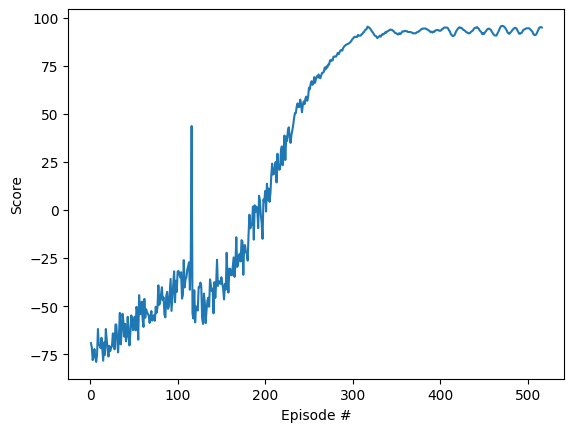

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()